<a href="https://colab.research.google.com/github/FadhillahAsmadee/Analysis-of-UPS-preventive-maintenance/blob/main/ARIMA_Modeling_Objective_2_Newer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from google.colab import drive
drive.mount('/content/drive')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm


In [5]:

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/testfinal_reduced.csv', parse_dates=['time'], index_col='time')

In [7]:
data.describe()

,Base_Config_Num_Device,Battery_Status,Battery_Voltage,Capacity,Config_Rated_Output_Voltage,Date_Manufacture,Full_Charge_Voltage,Input_Frequency,Input_Line_Voltage,Input_Max_Line_Voltage,Input_Min_Line_Voltage,Last_Replacement_Date,Output_Frequency,Output_Line_Voltage,Output_Load,Output_Status,Remaining_Time,Replacement,Temperature,Time_On_Battery
count,100000.0,1207.0,100000.000000,100000.000000,100000.0,0.0,100000.000000,1178.000000,100000.000000,100000.000000,1515.000000,0.0,100000.000000,100000.000000,1178.000000,100000.000000,100000.00000,100000.0,100000.000000,100000.000000
mean,4.0,2.0,22.006910,96.669250,2300.0,NaN,857.988000,456.140068,2412.558980,2509.544190,2248.163696,NaN,498.449050,2298.762290,5.824278,2.008130,15.77772,0.0,281.566100,2.250820
std,0.0,0.0,0.149005,3.334079,0.0,NaN,538.365945,139.601119,86.037297,61.491142,604.577547,NaN,16.678988,6.354988,3.199754,0.170834,655.20829,0.0,40.322532,84.754814
min,4.0,2.0,20.000000,55.000000,2300.0,NaN,360.000000,0.000000,0.000000,2407.000000,0.000000,NaN,0.000000,2287.000000,0.000000,2.000000,0.00000,0.0,230.000000,0.000000
25%,4.0,2.0,22.000000,93.000000,2300.0,NaN,360.000000,499.000000,2397.000000,2452.000000,2388.000000,NaN,499.000000,2297.000000,7.000000,2.000000,0.00000,0.0,250.000000,0.000000
50%,4.0,2.0,22.000000,95.000000,2300.0,NaN,360.000000,499.000000,2415.000000,2457.000000,2408.000000,NaN,499.000000,2300.000000,7.000000,2.000000,0.00000,0.0,250.000000,0.000000
75%,4.0,2.0,22.000000,100.000000,2300.0,NaN,1440.000000,499.000000,2433.000000,2576.000000,2426.000000,NaN,499.000000,2300.000000,8.000000,2.000000,0.00000,0.0,320.000000,0.000000
max,4.0,2.0,24.000000,100.000000,2300.0,NaN,1440.000000,500.000000,2573.000000,2576.000000,2460.000000,NaN,500.000000,2466.000000,8.000000,6.000000,53991.00000,0.0,400.000000,5095.000000


# Data Cleansing

In [8]:
data_new=data.drop(['name','Last_Replacement_Date','Date_Manufacture','Config_Rated_Output_Voltage','Replacement','Base_Config_Num_Device','Battery_Status','Input_Max_Line_Voltage','Input_Min_Line_Voltage','host','Output_Status','Remaining_Time','Time_On_Battery','Output_Frequency','Input_Line_Voltage'], axis=1)

In [9]:
# Format the index column as datetime
data_new.index = pd.to_datetime(data_new.index, format='%Y-%m-%dT%H:%M:%S.%fZ')

# Format the index column as a string
data_new.index = data_new.index.strftime('%Y-%m-%d %H:%M:%S')

In [10]:
data_new.head()

,Battery_Voltage,Capacity,Full_Charge_Voltage,Input_Frequency,Output_Line_Voltage,Output_Load,Temperature
time,,,,,,,
2022-12-26 02:00:59,22,100,1440,NaN,2301,NaN,350
2023-01-01 13:27:35,22,93,360,NaN,2300,NaN,250
2022-12-25 03:11:24,22,100,1440,NaN,2293,NaN,330
2023-01-12 05:12:32,22,95,360,NaN,2300,NaN,250
2022-12-20 12:21:19,22,95,360,NaN,2300,NaN,250


In [11]:
data_new.isna().sum().where(lambda x: x>0)

Battery_Voltage            NaN
Capacity                   NaN
Full_Charge_Voltage        NaN
Input_Frequency        98822.0
Output_Line_Voltage        NaN
Output_Load            98822.0
Temperature                NaN
dtype: float64

In [12]:
# impute the missing values with mean
data_new['Input_Frequency'] = data_new['Input_Frequency'].fillna(data_new['Input_Frequency'].mean())
data_new['Output_Load'] = data_new['Output_Load'].fillna(data_new['Output_Load'].mean())

In [13]:
# to standardize the data
data_new['Temperature'] = (data_new['Temperature'] * 0.10).round(2)
data_new['Full_Charge_Voltage'] = (data_new['Full_Charge_Voltage'] * 0.10).round(2)
data_new['Output_Line_Voltage'] = (data_new['Output_Line_Voltage'] * 0.10).round(2)

#data_new['Input_Max_Line_Voltage'] = (data_new['Input_Max_Line_Voltage'] * 0.10).round(2)
#data_new['Input_Min_Line_Voltage'] = (data_new['Input_Min_Line_Voltage'] * 0.10).round(2)
#data_new['Input_Line_Voltage'] = (data_new['Input_Line_Voltage'] * 0.10).round(2)

In [14]:
data_new.columns

Index(['Battery_Voltage', 'Capacity', 'Full_Charge_Voltage', 'Input_Frequency',
       'Output_Line_Voltage', 'Output_Load', 'Temperature'],
      dtype='object')

# Check assumptions

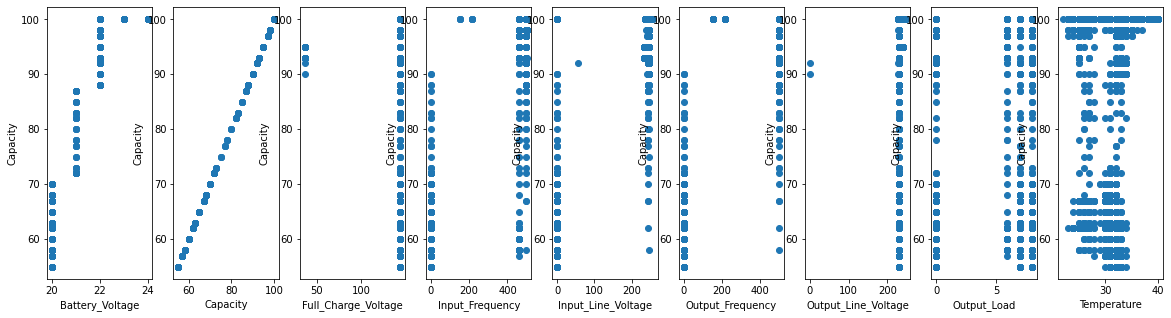

In [ ]:
# Check linearity assumption
fig, axes = plt.subplots(nrows=1, ncols=len(data_new.columns), figsize=(20, 5))
for i, col in enumerate(data_new.columns):
    axes[i].scatter(data_new[col], data_new['Capacity'])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Capacity')
plt.show()

In [ ]:
# Check stationarity assumption
#fig, axes = plt.subplots(nrows=len(data_new.columns), ncols=1, figsize=(10, 10))
#for i, col in enumerate(data_new.columns):
 #   sm.graphics.tsa.plot_acf(data_new[col], ax=axes[i], title=col)
#plt.show()

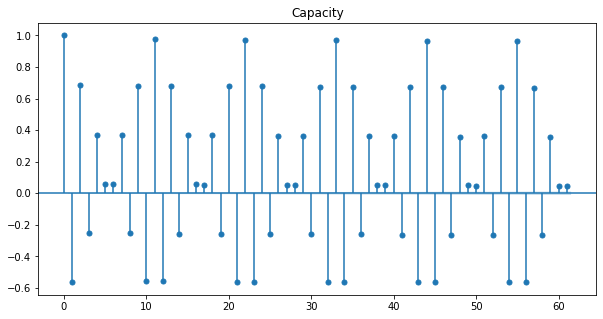

In [ ]:
# Check autocorrelation assumption
fig, ax = plt.subplots(figsize=(10, 5))
sm.graphics.tsa.plot_acf(data_new['Capacity'], ax=ax, title='Capacity')
plt.show()

Check Assumptions 2.0

In [15]:
data_new.columns

Index(['Battery_Voltage', 'Capacity', 'Full_Charge_Voltage', 'Input_Frequency',
       'Output_Line_Voltage', 'Output_Load', 'Temperature'],
      dtype='object')

In [16]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_new['Temperature'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -315.740557
p-value: 0.000000


In [17]:
result = adfuller(data_new['Output_Line_Voltage'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -316.664372
p-value: 0.000000


In [18]:
result = adfuller(data_new['Output_Load'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -159.177320
p-value: 0.000000


In [23]:
model = sm.tsa.VAR(data_new)
results = model.fit()
residuals = results.resid
for col in residuals.columns:
    print("Normality test of residuals for", col, ":\n", sm.stats.acorr_ljungbox(residuals[col], lags=[20], boxpierce=True))


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Normality test of residuals for Battery_Voltage :
       lb_stat  lb_pvalue    bp_stat  bp_pvalue
20  22.320389   0.323382  22.317448   0.323536
Normality test of residuals for Capacity :
       lb_stat  lb_pvalue    bp_stat  bp_pvalue
20  30.338047   0.064558  30.334276   0.064615
Normality test of residuals for Full_Charge_Voltage :
       lb_stat  lb_pvalue    bp_stat  bp_pvalue
20  25.593181   0.179672  25.590096    0.17978
Normality test of residuals for Input_Frequency :
       lb_stat  lb_pvalue    bp_stat  bp_pvalue
20  32.013026    0.04316  32.008992   0.043203
Normality test of residuals for Output_Line_Voltage :
      lb_stat  lb_pvalue   bp_stat  bp_pvalue
20  8.768286   0.985439  8.767599   0.985446
Normality test of residuals for Output_Load :
       lb_stat  lb_pvalue   bp_stat  bp_pvalue
20  23.899709   0.246801  23.89688   0.246926
Normality test of residuals for Temperature :
       lb_stat  lb_pvalue    bp_stat  bp_pvalue
20  14.126795   0.824009  14.124975   0.82410

In [24]:
# create VAR model with all variables
model = sm.tsa.VAR(data_new)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [25]:
# fit the model
results = model.fit()

In [26]:
# print the summary of the model
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 03, Mar, 2023
Time:                     03:44:12
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    7.51423
Nobs:                     99999.0    HQIC:                   7.51052
Log likelihood:      -1.36863e+06    FPE:                    1824.21
AIC:                      7.50890    Det(Omega_mle):         1823.19
--------------------------------------------------------------------
Results for equation Battery_Voltage
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         22.132388         0.196130          112.845           0.000
L1.Battery_Voltage            -0.003066         0.003874           -0.791           0.429
L1.Capacity   

In [27]:
# forecast the next 5 values
forecast = results.forecast(data_new.values[-results.k_ar:], 5)
forecast = pd.DataFrame(forecast, index=data_new.index[-5:], columns=data_new.columns)

<AxesSubplot:xlabel='time'>

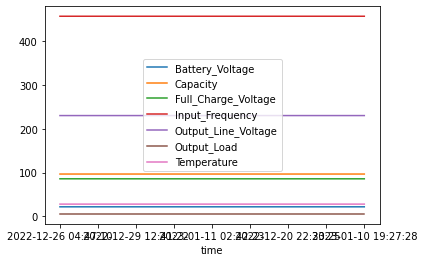

In [28]:
# plot the forecasts
forecast.plot()